# Implementing Maximum Likelihood and Bayes Estimators

George Ho 9/21/17

This notebook illustrates maximum likelihood and Bayesian estimation.

We consider three scenarios:
 - Estimating the binomial probability $p$ in a $B(n, p)$ model, where $n$ is known
 - Estimating the mean $\mu$ in an $N(\mu, \sigma^2)$ model, where $\sigma^2$ is known
 - Estimating the precision $\tau$ in an $N(\mu, 1/\tau)$ model, where $\mu$ is known

In each scenario, three prior distributions are considered and plotted. Each prior, as well as the maximum likelihood estimator, is used to do an online inference of the relevant parameter. The mean squared error is then plotted for all three priors, as well as the maximum likelihood estimator. Finally, the posterior distribution is plotted at various points in the online inference.

Note that this notebook implements _sequential/online learning_, where each _individual_ observation is processed one at a time, updating the hyperparameters after each observation is processed. This is in contrast to _batch learning_, where the _entire dataset_ of observations is processed at once, and the hyperparameters are thus updated only once.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

# Number of observations
data_size = 100

# Number of iterations to average over when computing the mean squared error
iterations = 1000

# Number of samples used to plot histograms
hist_size = 10000

## Beta-Binomial (estimating binomial probability $p$)

### Ground truth

In [2]:
# Ground truth
p = 0.3
n = 10

### Plotting priors

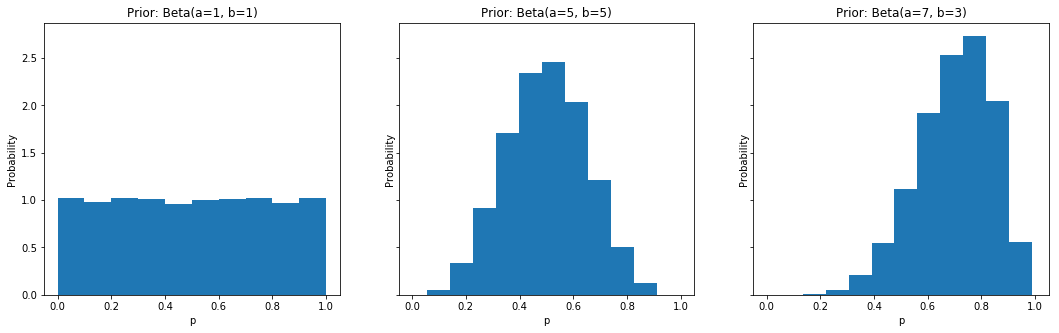

In [3]:
# Three sets of hyperparameters
hyperparams = [(1, 1), (5, 5), (7, 3)]

fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True, sharey=True)
priors = np.empty(shape=[hist_size, len(hyperparams)])

for i, ((a, b), ax) in enumerate(zip(hyperparams, axarr)):
    priors[:, i] = np.random.beta(a=a, b=b, size=hist_size)
    ax.hist(priors[:, i], normed=1)
    ax.set_title("Prior: Beta(a={0}, b={1})".format(a, b))
    ax.set_ylabel("Probability")
    ax.set_xlabel("p")

plt.show()

### MAP and ML estimation

In [4]:
ensemble_map_ests = []
ensemble_ml_ests = []

for _ in range(iterations):
    # Observations
    X = np.random.binomial(n, p, data_size)

    # MAP estimate
    map_params = np.empty(shape=[len(X)+1, len(hyperparams)*len(hyperparams[0])])
    map_params[0, :] = list(chain(*hyperparams))

    for i, x in enumerate(X):
        # Update rule for binomial model with beta prior for p
        map_params[i+1, :] = map_params[i, :] + np.tile([x, n-x], 3)

    # Expectation of Beta(a,b) = a/(a+b)
    # Also, throw away the prior estimate
    map_ests = (map_params[:, ::2] / (map_params[:, ::2] + map_params[:, 1::2]))[1:, :]

    # ML estimate
    ml_ests = np.empty(shape=[len(X), 1])

    for i in range(len(X)):
        # Mean of observations
        ml_ests[i] = np.mean(X[:i+1]/n)

    ensemble_map_ests.append(map_ests)
    ensemble_ml_ests.append(ml_ests)

avg_map_ests = np.dstack(ensemble_map_ests).mean(axis=2)
avg_ml_ests = np.dstack(ensemble_ml_ests).mean(axis=2)

### Plotting mean squared error

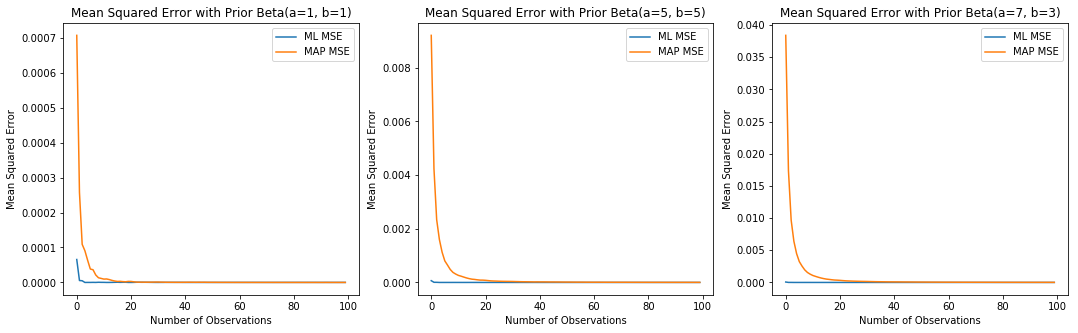

In [5]:
fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True)
ml_mean_sq_err = (avg_ml_ests - p)**2
map_mean_sq_err = (avg_map_ests - p)**2

for i, (ax, (a, b)) in enumerate(zip(axarr, hyperparams)):
    ax.plot(ml_mean_sq_err, label='ML MSE')
    ax.plot(map_mean_sq_err[:, i], label='MAP MSE')
    ax.set_title("Mean Squared Error with Prior Beta(a={0}, b={1})".format(a, b))
    ax.legend()
    ax.set_ylabel("Mean Squared Error")
    ax.set_xlabel("Number of Observations")

plt.show()

### Plotting posteriors for various observations

We use the first set of hyperparameters in `hyperparams` (i.e. a $Beta(1, 1)$ prior) to illustrate this.

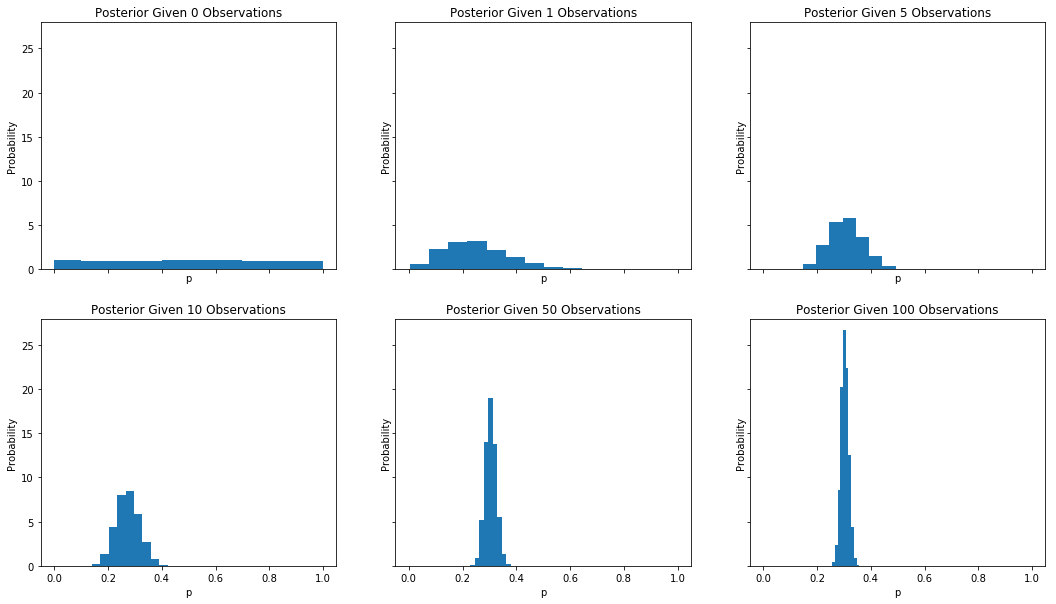

In [6]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[18, 10], sharex=True, sharey=True)
num_obs = [0, 1, 5, 10, 50, 100]

for i, (num, ax) in enumerate(zip(num_obs, axarr.flatten())):
    samp = np.random.beta(a=map_params[num, 0], b=map_params[num, 1], size=hist_size)
    ax.hist(samp, normed=True)
    ax.set_title("Posterior Given {} Observations".format(num))
    ax.set_ylabel("Probability")
    ax.set_xlabel("p")
    
plt.show()

## Gaussian with Known Variance (estimating mean $μ$)

### Ground Truth

In [7]:
# Ground truth
mu = -2
sigma = 4

### Plotting priors

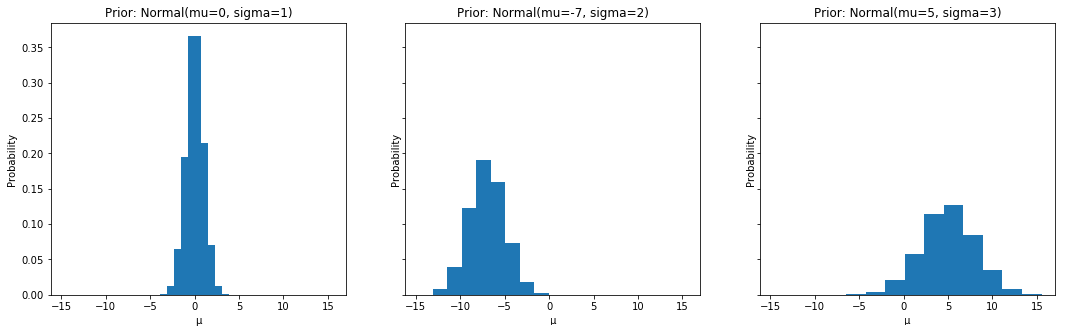

In [8]:
# Three sets of hyperparameters
hyperparams = [(0, 1), (-7, 2), (5, 3)]

fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True, sharey=True)
priors = np.empty(shape=[hist_size, len(hyperparams)])

for i, ((mu_0, sigma_0), ax) in enumerate(zip(hyperparams, axarr)):
    priors[:, i] = np.random.normal(loc=mu_0, scale=sigma_0, size=hist_size)
    ax.hist(priors[:, i], normed=True)
    ax.set_title("Prior: Normal(mu={0}, sigma={1})".format(mu_0, sigma_0))
    ax.set_ylabel("Probability")
    ax.set_xlabel("μ")

plt.show()

### MAP and ML estimation

In [9]:
ensemble_map_ests = []
ensemble_ml_ests = []

for _ in range(iterations):
    # Observations
    X = np.random.normal(loc=mu, scale=sigma, size=data_size)

    # MAP
    map_params = np.zeros(shape=[len(X)+1, len(hyperparams)*len(hyperparams[0])])
    map_params[0,:] = list(chain(*hyperparams))

    for i, x in enumerate(X):
        # Update rule for normal model with normal prior for mu. Online learning.
        coeff = sigma**2 / (map_params[i, 1::2]**2 + sigma**2)
        map_params[i+1, ::2] = coeff*map_params[i, ::2] + (1-coeff)*x
        map_params[i+1, 1::2] = np.sqrt(1/(1/(map_params[i, 1::2]**2) + 1/sigma**2))

    # Expectation of N(mu, sigma^2) = mu
    # Also, throw away the prior estimate
    map_ests = map_params[1:, ::2]

    # ML
    ml_ests = np.empty(shape=[len(X), 1])

    for i in range(len(X)):
        ml_ests[i] = np.mean(X[:i+1])

    ensemble_map_ests.append(map_ests)
    ensemble_ml_ests.append(ml_ests)

avg_map_ests = np.dstack(ensemble_map_ests).mean(axis=2)
avg_ml_ests = np.dstack(ensemble_ml_ests).mean(axis=2)

### Plotting mean squared error

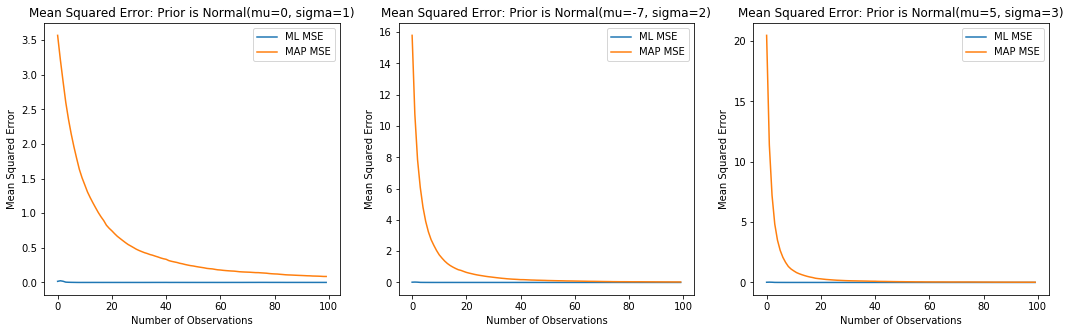

In [10]:
fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True)
ml_mean_sq_err = (avg_ml_ests - mu)**2
map_mean_sq_err = (avg_map_ests - mu)**2

for i, (ax, (mu_0, sigma_0)) in enumerate(zip(axarr, hyperparams)):
    ax.plot(ml_mean_sq_err, label='ML MSE')
    ax.plot(map_mean_sq_err[:, i], label='MAP MSE')
    ax.set_title("Mean Squared Error: Prior is Normal(mu={0}, sigma={1})".format(mu_0, sigma_0))
    ax.legend()
    ax.set_ylabel("Mean Squared Error")
    ax.set_xlabel("Number of Observations")

plt.show()

### Plotting posteriors for various observations

We use the first set of hyperparameters in `hyperparams` (i.e. a $N(0, 1)$ prior) to illustrate this.

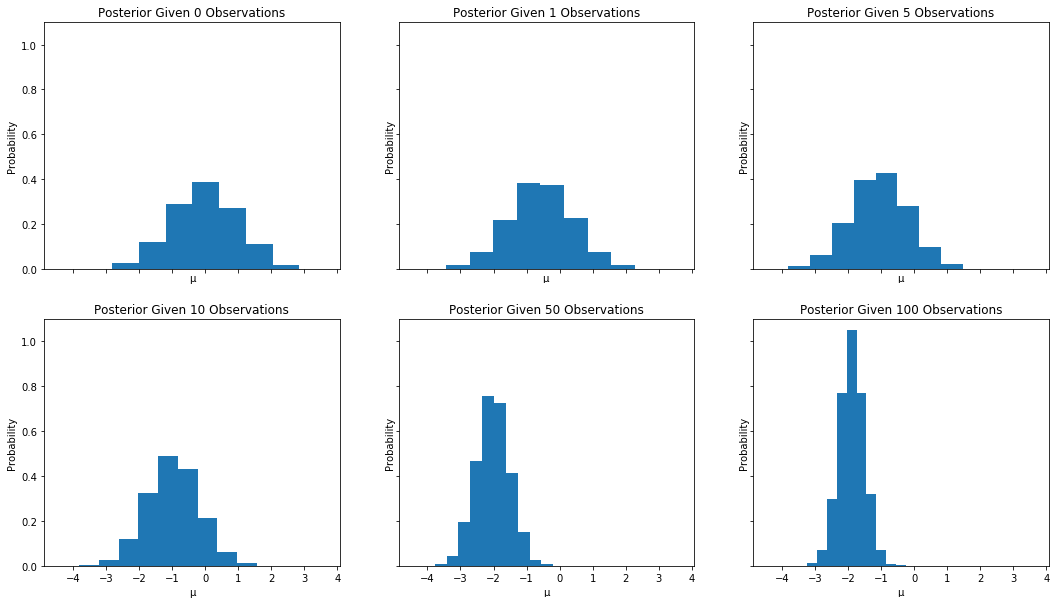

In [11]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[18, 10], sharex=True, sharey=True)
num_obs = [0, 1, 5, 10, 50, 100]

for i, (num, ax) in enumerate(zip(num_obs, axarr.flatten())):
    samp = np.random.normal(loc=map_params[num, 0], scale=map_params[num, 1], size=hist_size)
    ax.hist(samp, normed=True)
    ax.set_title("Posterior Given {} Observations".format(num))
    ax.set_ylabel("Probability")
    ax.set_xlabel("μ")
    
plt.show()

## Gaussian with Known Mean (estimating precision $τ$)

### Ground Truth

In [12]:
# Ground truth
mu = 3
tau = 1/4

### Plotting priors

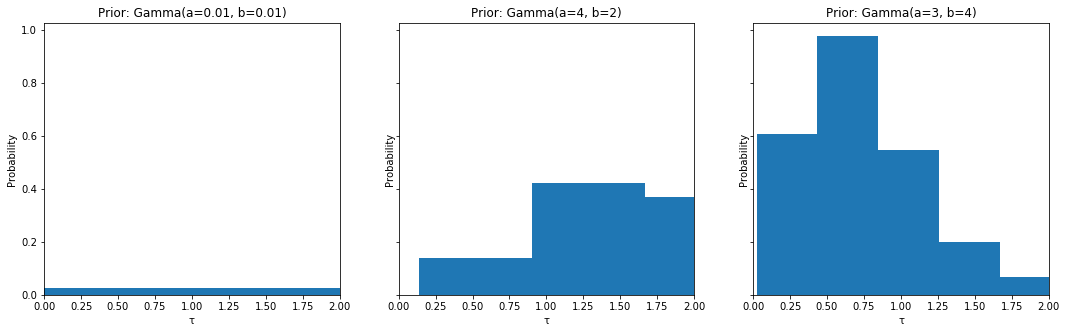

In [13]:
# 3 sets of hyperparameters
hyperparams = [(0.01, 0.01), (4, 2), (3, 4)]

fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True, sharey=True)
priors = np.empty(shape=[hist_size, len(hyperparams)])

for i, ((a, b), ax) in enumerate(zip(hyperparams, axarr)):
    # NumPy uses k and theta and not alpha and beta. The 1/ is to compensate for this
    priors[:, i] = np.random.gamma(shape=a, scale=1/b, size=hist_size)
    ax.hist(priors[:, i], normed=True)
    ax.set_xlim([0, 2])
    ax.set_title("Prior: Gamma(a={0}, b={1})".format(a, b))
    ax.set_ylabel("Probability")
    ax.set_xlabel("τ")

plt.show()

### MAP and ML estimation

In [14]:
ensemble_map_ests = []
ensemble_ml_ests = []

for _ in range(iterations):
    # Observations
    X = np.random.normal(loc=mu, scale=np.sqrt(1/tau), size=data_size)

    # MAP
    map_params = np.empty(shape=[len(X)+1, len(hyperparams)*len(hyperparams[0])])
    map_params[0,:] = list(chain(*hyperparams))

    for i, x in enumerate(X):
        # Update rule for Gaussian model with Gamma prior for tau. Online learning.
        map_params[i+1, ::2] = map_params[i, ::2] + 1/2
        map_params[i+1, 1::2] = map_params[i, 1::2] + ((x - mu)**2)/2

    # Expectation of Gamma(a,b) = a/b
    # Also, throw away the prior estimate
    map_ests = map_params[1:, ::2] / map_params[1:, 1::2]

    # ML
    ml_ests = np.empty(shape=[len(X), 1])

    for i, x in enumerate(X):
        ml_ests[i] = 1/(np.sum((X[:i+1] - mu)**2)/(i+1))
        
    ensemble_map_ests.append(map_ests)
    ensemble_ml_ests.append(ml_ests)

avg_map_ests = np.dstack(ensemble_map_ests).mean(axis=2)
avg_ml_ests = np.dstack(ensemble_ml_ests).mean(axis=2)

### Plotting mean squared error

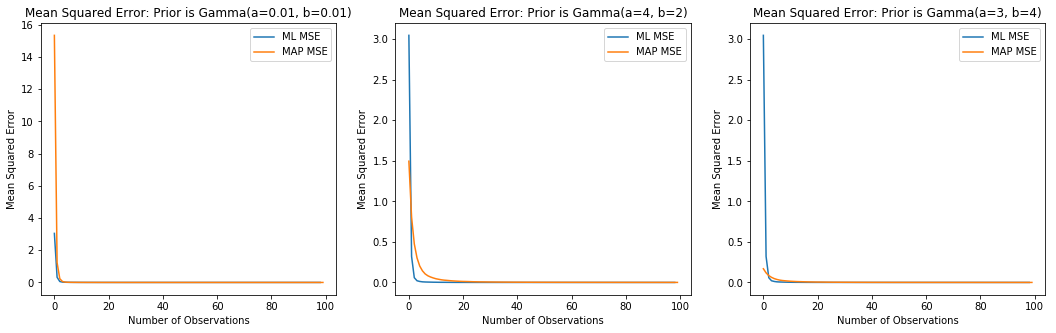

In [15]:
fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True)
ml_mean_sq_err = (avg_ml_ests - tau)**2
map_mean_sq_err = (avg_map_ests - tau)**2

for i, (ax, (a, b)) in enumerate(zip(axarr, hyperparams)):
    ax.plot(ml_mean_sq_err[1:], label='ML MSE')
    ax.plot(map_mean_sq_err[:, i], label='MAP MSE')
    ax.set_title("Mean Squared Error: Prior is Gamma(a={0}, b={1})".format(a, b))
    ax.legend()
    ax.set_ylabel("Mean Squared Error")
    ax.set_xlabel("Number of Observations")

plt.show()

### Plotting posteriors for various observations

We use the first set of hyperparameters in `hyperparams` (i.e. a $Gamma(0.01, 0.01)$ prior) to illustrate this.

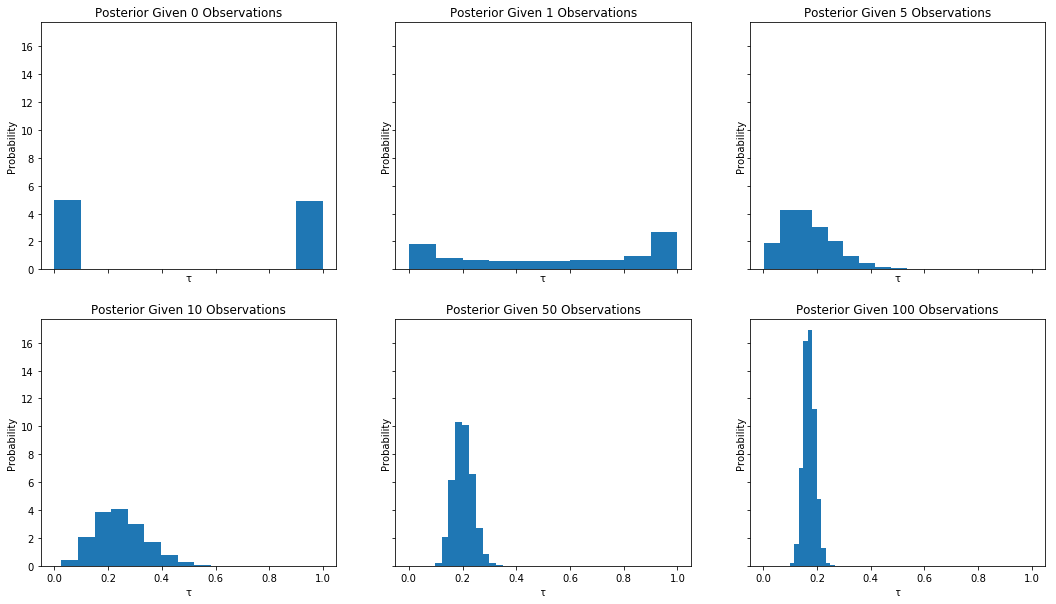

In [16]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[18, 10], sharex=True, sharey=True)
num_obs = [0, 1, 5, 10, 50, 100]

for i, (num, ax) in enumerate(zip(num_obs, axarr.flatten())):
    foo = np.random.beta(a=map_params[num, 0], b=map_params[num, 1], size=hist_size)
    ax.hist(foo, normed=True)
    ax.set_title("Posterior Given {} Observations".format(num))
    ax.set_ylabel("Probability")
    ax.set_xlabel("τ")
    
plt.show()